## **Simple Blog Agent**


In [1]:
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from typing import TypedDict
from pydantic import BaseModel, Field

In [2]:
# blog agent state
class BlogState(TypedDict):
    topic: str
    outline: str
    final_blog: str
    blog_score: float

In [3]:
class BlogScore(BaseModel):
    score: float = Field(..., ge=0.0, le=10.0,
                         description="Score must be between 0.0 and 10.0")

In [4]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.7)

In [5]:
# nodes
def create_outline(state: BlogState) -> BlogState:
    """this node will create a outline of the blog on the given topic"""
    topic = state['topic']
    prompt = f"Generate a detailed outline for the blog on the topic: {topic}"

    response = llm.invoke(prompt).content

    state['outline'] = response

    return state

In [6]:
def create_blog(state: BlogState) -> BlogState:
    """this node will create a blog on the following outline created by the outline node"""
    title = state['topic']
    outline = state['outline']
    prompt = f"Write a detailed blog on the title: {title} based on the following outline:\n{outline}"

    response = llm.invoke(prompt).content

    state['final_blog'] = response

    return state

In [7]:
def blog_score(state: BlogState) -> BlogState:
    """this node will only give a integer score to a blog based on the outline of the blog."""
    blog = state['final_blog']
    outline = state['outline']
    prompt = f"""
    You are a blog evaluator. Analyze the following blog and give it a score out of 10 based on how well it follows the outline.

    Outline:
    {outline}

    Blog:
    {blog}

    Return ONLY a JSON object with a 'score' field (a number between 0.0 and 10.0). Do not include any explanation or additional text.

    Example format: {{"score": 8.5}}
"""

    llm_with_structure = llm.with_structured_output(BlogScore)
    response = llm_with_structure.invoke(prompt)

    state['blog_score'] = response.score

    return state

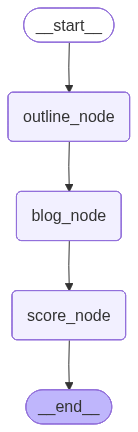

In [8]:
graph = StateGraph(BlogState)

graph.add_node("outline_node", create_outline)
graph.add_node("blog_node", create_blog)
graph.add_node("score_node", blog_score)

graph.add_edge(START, "outline_node")
graph.add_edge("outline_node", "blog_node")
graph.add_edge("blog_node", "score_node")
graph.add_edge("score_node", END)

app = graph.compile()
app

In [9]:
response = app.invoke({"topic": "the growth of ai in india"})

In [10]:
print(response["final_blog"])

Of course! Here is a detailed blog post crafted from the provided outline.

---

# The AI Awakening: Charting the Explosive Growth of Artificial Intelligence in India

A farmer in Punjab receives a smartphone alert about an impending pest attack, saving his season's yield. A patient in a remote village gets a preliminary diagnosis from a telemedicine app powered by a sophisticated algorithm. These aren't scenes from a sci-fi movie; they are real glimpses of today's India, where Artificial Intelligence is rapidly moving from research labs into everyday lives.

AI has shed its buzzword status to become a core component of India's ambitious digital transformation story. It's a narrative not just of technological adoption, but of a nation leveraging its unique strengths to solve complex problems at scale. This blog delves into the multifaceted growth of AI in India, exploring the powerful drivers, the sectors being transformed, the challenges on the path, and the promising future that lies

In [13]:
print(response["blog_score"])

9.7
